Notebook used to test swaping one target and source image at a time without having to reload the whole model each time.

In [78]:

import cv2
import torch
import fractions
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms
from options.test_options import TestOptions
from insightface_func.face_detect_crop_single import Face_detect_crop
from util.reverse2original import reverse2wholeimage
import os
from util.add_watermark import watermark_image
from util.norm import SpecificNorm
from parsing_model.model import BiSeNet
import wandb
from models.projected_model import fsModel

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

In [79]:
torch.cuda.set_device(1)
def lcm(a, b): return abs(a * b) / fractions.gcd(a, b) if a and b else 0

transformer_Arcface = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def _totensor(array):
    tensor = torch.from_numpy(array)
    img = tensor.transpose(0, 1).transpose(0, 2).contiguous()
    return img.float().div(255)

def str2bool(v):
    return v.lower() in ('true')

In [80]:
import numpy as np
import math
import PIL
torch.cuda.set_device(1)
def postprocess(x):
    """[0,1] to uint8."""
    
    x = np.clip(255 * x, 0, 255)
    x = np.cast[np.uint8](x)
    return x

def tile(X, rows, cols):
    """Tile images for display."""
    tiling = np.zeros((rows * X.shape[1], cols * X.shape[2], X.shape[3]), dtype = X.dtype)
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < X.shape[0]:
                img = X[idx,...]
                tiling[
                        i*X.shape[1]:(i+1)*X.shape[1],
                        j*X.shape[2]:(j+1)*X.shape[2],
                        :] = img
    return tiling
def plot_batch(X, out_path):
    """Save batch of images tiled."""
    # n_channels = X.shape[3]
    # if n_channels > 3:
    #     X = X[:,:,:,np.random.choice(n_channels, size = 3)]
    X = postprocess(X)
    # rc = math.sqrt(X.shape[0])
    # rows = cols = math.ceil(rc)
    # canvas = tile(X, rows, cols)
    # print('canvas',canvas.shape)
    # canvas = np.squeeze(canvas)
    X = np.squeeze(X)
    # print('canvas',X.shape)
    # out_img = PIL.Image.fromarray(canvas)
    # out_img.save(out_path)
#     images_output_wandb = wandb.Image(canvas, caption="Output images")      
#     wandb.log({"images_sample": images_output_wandb})
    return X
# import wandb


python test_wholeimage_swapsingle.py --isTrain false --name people --Arc_path arcface_model/arcface_checkpoint.tar --pic_a_path ./demo_file/putin2022.jpg  --pic_b_path ./demo_file/me_800x800.jpg --output_path ./output/ --checkpoints_dir ./checkpoints/simswap224_retry --which_epoch 800000

In [81]:
opt = TestOptions()
torch.cuda.set_device(1)

opt.parser.add_argument('-f') ## dummy arg to avoid bug
opt.parser.add_argument('--Gdeep', type=str2bool, default='False')
opt.parser.add_argument('--transf', type=str2bool, default='False')


opt = opt.parse()
opt.isTrain = False
opt.name = 'people'
opt.Arc_path = 'arcface_model/arcface_checkpoint.tar'
opt.pic_a_path = './demo_file/putin2022.jpg'
opt.pic_b_path = './demo_file/Iron_man.jpg'
# opt.pic_b_path = './demo_file/me_800x800.jpg'
# opt.pic_a_path = './demo_file/specific1.png'
# opt.pic_b_path = './demo_file/specific3.png'
opt.output_path = './output/'
opt.checkpoints_dir = './checkpoints/simswap224_retry'
opt.which_epoch = 700000
opt.gpu_ids = [1]
# print(opt)


------------ Options -------------
Arc_path: models/BEST_checkpoint.tar
Gdeep: False
aspect_ratio: 1.0
batchSize: 8
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
crop_size: 224
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
f: /home/astro/.local/share/jupyter/runtime/kernel-6524823d-496f-4576-92ba-19eafbd5fb82.json
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
id_thres: 0.03
image_size: 224
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 0
latent_size: 512
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
multisepcific_dir: ./demo_file/multispecific
nThreads: 2
n_blocks_global: 6
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 3
n_local_enhancers: 1
name: people
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
no_simswaplogo: False
norm: batch
norm_G: spectralspadesync

In [82]:

torch.cuda.set_device(opt.gpu_ids[0])
start_epoch, epoch_iter = 1, 0
crop_size = opt.crop_size

torch.nn.Module.dump_patches = True
if crop_size == 512:
    opt.which_epoch = 550000
    opt.name = '512'
    mode = 'ffhq'
else:
    mode = 'None'
logoclass = watermark_image('./simswaplogo/simswaplogo.png')

(142, 366, 4)


In [83]:
model = fsModel()
model.initialize(opt)
model.netG.eval()
spNorm =SpecificNorm() 
app = Face_detect_crop(name='antelope', root='./insightface_func/models',cuda_device = opt.gpu_ids[0])
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640),mode=mode)


================  Generator Architecture ================
1
NVIDIA GeForce RTX 2060 SUPER
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


In [84]:
torch.cuda.set_device(opt.gpu_ids[0])
final_image = None
with torch.no_grad():
    pic_a = opt.pic_a_path

    img_a_whole = cv2.imread(pic_a)
    img_a_align_crop, _ = app.get(img_a_whole,crop_size)
    img_a_align_crop_pil = Image.fromarray(cv2.cvtColor(img_a_align_crop[0],cv2.COLOR_BGR2RGB)) 
    img_a = transformer_Arcface(img_a_align_crop_pil)
    img_id = img_a.view(-1, img_a.shape[0], img_a.shape[1], img_a.shape[2])

    # convert numpy to tensor
    img_id = img_id.cuda(int(opt.gpu_ids[0]))

    #create latent id
    img_id_downsample = F.interpolate(img_id, size=(112,112), mode='bicubic')
    latend_id = model.netArc(img_id_downsample)
    latend_id = F.normalize(latend_id, p=2, dim=1)


    ############## Forward Pass ######################

    pic_b = opt.pic_b_path
    img_b_whole = cv2.imread(pic_b)

    img_b_align_crop_list, b_mat_list = app.get(img_b_whole,crop_size)
    # detect_results = None
    swap_result_list = []

    b_align_crop_tenor_list = []
    mean = torch.tensor([0.485, 0.456, 0.406]).cuda(int(opt.gpu_ids[0])).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).cuda(int(opt.gpu_ids[0])).view(1,3,1,1)

    imagenet_std    = torch.Tensor([0.229, 0.224, 0.225]).view(3,1,1)
    imagenet_mean   = torch.Tensor([0.485, 0.456, 0.406]).view(3,1,1)
    for b_align_crop in img_b_align_crop_list:

        img_tensor = _totensor(cv2.cvtColor(b_align_crop,cv2.COLOR_BGR2RGB))[None,...].cuda(int(opt.gpu_ids[0]))
        #New
        #  tensor = torch.from_numpy(array)
        # img = tensor.transpose(0, 1).transpose(0, 2).contiguous()
        # return img.float().div(255)
        # print(b_align_crop)
        # img_tensor = transforms.ToTensor()(cv2.cvtColor(b_align_crop,cv2.COLOR_BGR2RGB)).cuda(non_blocking=True) 
        img_tensor = img_tensor.view(-1, 3, 224,224)   #HARDCODED
        print(img_tensor.shape)
        b_align_crop_tenor =  img_tensor.sub_(mean).div_(std)

        swap_result = model.netG(b_align_crop_tenor, latend_id)#.cpu()
        swap_result = swap_result.mul_(std).add_(mean)#
        # swap_result    = swap_result * imagenet_std
        # swap_result    = swap_result + imagenet_mean 
        # torch.clip
        # print(torch.max(swap_result))
        # print(torch.min(swap_result))
        # swap_result = torch.clip(255 * swap_result, 0, 255)
        # swap_result = swap_result.to(torch.uint8)
        # x = torch.cast[np.uint8](x)
        # swap_result = swap_result[0]
        # swap_result = swap_result + mean
        # b_align_crop_tenor = (b_align_crop_tenor * std)+mean
        swap_result_list.append(swap_result)
        b_align_crop_tenor_list.append(b_align_crop_tenor)

        net = None
        print(swap_result[0].shape)
        import PIL
        # PIL.Image.fromarray(swap_result[0].cpu().numpy()).save(os.path.join(opt.output_path, 'result_whole_swapsingle_cropped.jpg'))
        # cv2.imwrite(os.path.join(opt.output_path, 'result_whole_swapsingle_cropped.jpg'), swap_result[0].cpu().numpy())
        final_image = reverse2wholeimage(b_align_crop_tenor_list, swap_result_list, b_mat_list, crop_size, img_b_whole, logoclass, \
            os.path.join(opt.output_path, 'result_whole_swapsingle.jpg'), no_simswaplogo = True, pasring_model =net,use_mask=opt.use_mask, norm = spNorm)

        print(' ')
        print('Output: ',os.path.join(opt.output_path, 'result_whole_swapsingle.jpg'))
        print('************ Done ! ************')
       

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
 
Output:  ./output/result_whole_swapsingle.jpg
************ Done ! ************


In [85]:
# torch.cuda.set_device(1)
# torch.cuda.current_device()
# torch.cuda.get_device_name(0)
swap_result.get_device()

1

In [86]:
# plt.imshow(final_image)
# plt.show()


torch.Size([1, 3, 224, 224])
(224, 224, 3)
0


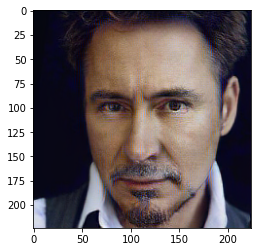

In [87]:
print(swap_result.shape)
s_img = swap_result.clone().cpu().numpy()[0]

s_img = s_img.transpose(1,2,0)
print(s_img.shape)
s_img = np.clip(255 * s_img, 0, 255)
s_img = np.rint(s_img)
s_img = np.cast[np.uint8](s_img)

print(s_img.min())
PIL.Image.fromarray(s_img).save(os.path.join('./demo_file/', 'example2.jpg'))
aabs = np.array(s_img)
plt.imshow(aabs,alpha=1)
plt.show()

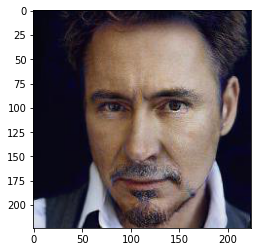

In [88]:
a = plt.imread( os.path.join('./demo_file/', 'example2.jpg'))
plt.imshow(a)
plt.show()

(3, 224, 224)
(224, 224, 3)


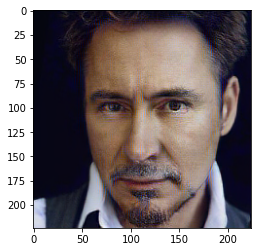

In [89]:
swap_np = swap_result_list[0][0].cpu().numpy()
# swap_np = swap_np.transpose(1,2,0)
swap_np= np.clip(255 * swap_np, 0, 255)
swap_np = np.cast[np.uint8](swap_np)
print(swap_np.shape)
# swap_np = swap_np.reshape(swap_np.shape[1],swap_np.shape[2],swap_np.shape[0])
swap_np = swap_np.transpose(1,2,0)
print(swap_np.shape)
plt.imshow(swap_np)
plt.show()